In [4]:
import matplotlib.pyplot as plt
from numpy import linalg
from cmath import *
from math import *
import numpy as np

In [5]:
"""
Returns the angular frequency w('omega') given the linear frequency f('freq')
"""
def omega(freq):
    return 2*pi*freq

"""
Returns the phasorial representation of a resistor given it's resistance ('R')
"""
def Z_R(R):
    return R

"""
Returns the phasorial representation of a capacitor given it's capacitance (in F) and the system frequency (both in rad/s or in Hz)
"""
def Z_C(w, C, f_in_Hz=False):
    if f_in_Hz:
        w = omega(w)
    return 1/(1j*w*C)

"""
Returns the phasorial representation of a inductor given it's inductance (in H) and the system frequency (in both rad/s or in Hz)
"""
def Z_L(w, L, f_in_Hz=False):
    if f_in_Hz:
        w = omega(w)
    return 1j*w*L
"""
Returns the polar representation of a phasor given it's cartesian (rectangular) representation
"""
def Z_rect_to_pol(Z):
    return abs(Z), degrees(phase(Z))

"""
Shows a phasorial representation (in both polar and rectangular representations)
"""
def Z_show(Z, polar=True, before_text="", after_text=" "):
    if polar:
        mod, ang = Z_rect_to_pol(Z)
        print(before_text+"{} < {}º".format(mod, ang) + after_text)
    else:
        print(Z)
    
"""
Returns the equivalent reactance given two reactances connected in parallel
"""
def in_parallel(Za, Zb):
    return (Za * Zb) / (Za + Zb)

"""
Returns the equivalent reactance given two reactances connected in series
"""    
def in_series(Za, Zb):
    return Za + Zb

"""L
Returns the current on a specific component given the Ohm's law (I = U / R)
"""
def current(Vt, Zx):
    return Vt / Zx

"""
Returns the voltage on a specific component given the Ohm's law (U = R * I)
"""
def voltage(It, Zx):
    return It*Zx

"""
Returns the currents on a tranformer component given the equivalent impedance of each side of the circuit(Z1, Z2)
"""
def transformer(v1, w, m, z1, z2):
    xm = 1j*w*m
    Z=np.array([[z1, -xm],[-xm, z2]])
    V=np.array([v1,0])
    I=np.dot(linalg.inv(Z),V)
    return I[0], I[1]


![Circuit Model](modelo_v1.png "WPT Circuit Model")

C:\Users\Dual Stream\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


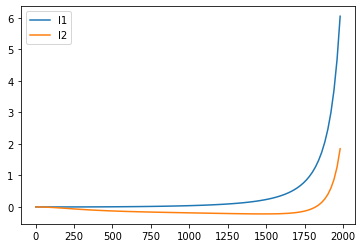

1825.7418583505537


In [26]:

# Natural ressonance frequency:

V = 1e3 # V

# 
lista_k=np.linspace(0,1,100)
lista_w = []
lista_v2 = []
lista_i1 = []
lista_i2 = []

# r1=0.5
# r2=0.5
# l1=300e-3
# l2=300e-3
# f=60
# k=0.5

for w in range(1, 2000, 20):
    lista_w.append(w)
    # Phasorial Representation of all components:
    L = 300e-3
    C = 1e-6
    R = 0.5
    XR1 = Z_R(R)   # Ohm
    XR2 = Z_R(R)   # Ohm
    XL1 = Z_L(w, L)  # Ohm
    XL2 = Z_L(w, L)  # Ohm
    XC1 = Z_C(w, C)  # Ohm
    XC2 = Z_C(w, C)  # Ohm
    XRC = Z_R(100)   # Ohm

    # Association between components:
    Zp1 = in_series(XC1, XR1)
    Z1 = in_series(XL1, Zp1)

    Zp2 = in_parallel(XC2, XRC)
    Zp3 = in_series(XR2, XL2)
    Z2 = in_series(Zp2, Zp3)


    k = 0.5
    m = k*sqrt(L*L)
    i1, i2 = transformer(V, w, m, Z1, Z2)
    lista_i1.append(i1)
    lista_i2.append(i2)

plt.plot(lista_w, lista_i1, label="I1")
plt.plot(lista_w, lista_i2, label="I2")
plt.legend()
plt.show()

w = 1/sqrt(L*C)
print(w)
